In [ ]:
%%capture
%cd /content
!rm -rf vape-classification/
!git clone https://github.com/sschott20/youtube-vape-classification
%cd youtube-vape-classification
%mkdir 'models'

In [ ]:
%%capture


import os
import tensorflow as tf

import keras
from numpy import array
from keras import models
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Bidirectional,GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

from keras.utils import np_utils
import matplotlib.pyplot as plt
!pip install langdetect
from langdetect import detect, detect_langs
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from zipfile import ZipFile
import nltk
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd
import numpy as np
import re
import random
import string

from langdetect import DetectorFactory
DetectorFactory.seed = 0


In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# downlaod embedding datasets from google drive

download = drive.CreateFile({'id': '1Pcow88UospIZfFX-qhEPt0wPs6EmwW0X'})
download.GetContentFile('/content/youtube-vape-classification/glove_small.zip')

with ZipFile('/content/youtube-vape-classification/glove_small.zip', 'r') as zipObj:
   zipObj.extractall()

with ZipFile('/content/youtube-vape-classification/channel_data.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# cutoff for each data, 
maxlen = 200

def preprocess_text(input_text):
    # remove special characters, numbers, spaces, and convert to lowercase
    output_text = input_text.lower()
    output_text = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', ' ', output_text)
    output_text = re.sub(r'[^a-zA-Z0-9 ]', '', output_text)
    output_text = re.sub(r'[0-9]+', ' number ', output_text)
    output_text = re.sub(r'\s+', ' ', output_text)

    return output_text

def process_text(input_text):
    # change from strings to a sequence of integers to input into model
    output_text = tokenizer.texts_to_sequences(input_text)
    output_text = pad_sequences(output_text, padding='post', truncating='post', maxlen=maxlen)
    return output_text


NameError: ignored

In [ ]:
embeddings_dictionary = dict()

with open('/content/youtube-vape-classification/glove.twitter.27B.100d.txt') as f:
    # transfer data from embedding datasets into a usable array
    for line in f:
        values = line.split()
        word = values[0]
        vector_dimensions = np.asarray(values[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions


In [ ]:
readable_data = pd.read_excel('/content/youtube-vape-classification/condensed_data.xlsx')
channel_data_root = '/content/youtube-vape-classification/content/vape-classification/channels_data/'

data = []



for i, row in readable_data.iterrows():
    exclude = False
    # read data from labeled dataset

    file_location = channel_data_root + row['Channel_URL'][32:] + ".xlsx"
    current_channel_data = pd.read_excel(file_location)

    # irrelevant videos are excluded 
    if row['model_1'] != '10':
        try:
            label = int(row['condensed_model_3'])
        except:
            exclude = True 
        
        for n, channel_video in current_channel_data.iterrows():
            if not exclude:

                # add text from video to x
                x = preprocess_text(str(channel_video['video_title']) + " " + str(channel_video['video_description']))
                # x = preprocess_text(str(channel_video['video_title']))

                # exclude entries with no text
                if len(x) > 0:

                    data.append([label, x])
                    # print([label,x])


In [ ]:
# vocab size
num_words = 1200

data_x = [i[1] for i in data]
data_y = [i[0] for i in data]


tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data_x)


In [ ]:

# initialize embedding matrix 
embedding_matrix = np.zeros((num_words, 100))
for word, index in tokenizer.word_index.items():
    if index > num_words - 1:
        break
    embedding_vector = embeddings_dictionary.get(word)    
    if  embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
encoder = LabelEncoder()
encoder.fit(data_y)
encoded_y = encoder.transform(data_y)
dummy_y = np_utils.to_categorical(encoded_y)



model = Sequential()
model.add(Embedding(num_words, 100, weights=[embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(128)))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(150, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.Precision(), keras.metrics.Recall()])

x_train_text, x_test_text, y_train, y_test = train_test_split(data_x, dummy_y, test_size = 0.2, random_state=1)
batch_size = 32
epochs = 10

x_train = process_text(x_train_text)
x_test = process_text(x_test_text)

history = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(x_test, y_test))

Epoch 1/10
249/249 [==============================] - 132s 439ms/step - loss: 1.1644 - acc: 0.5375 - precision: 0.3287 - recall: 0.8719 - val_loss: 0.7016 - val_acc: 0.7472 - val_precision: 0.4281 - val_recall: 0.9442
Epoch 2/10
249/249 [==============================] - 108s 436ms/step - loss: 0.6388 - acc: 0.7746 - precision: 0.4509 - recall: 0.9483 - val_loss: 0.5518 - val_acc: 0.8045 - val_precision: 0.4833 - val_recall: 0.9452
Epoch 3/10
249/249 [==============================] - 108s 436ms/step - loss: 0.4800 - acc: 0.8344 - precision: 0.5018 - recall: 0.9624 - val_loss: 0.5327 - val_acc: 0.8035 - val_precision: 0.5037 - val_recall: 0.9538
Epoch 4/10
249/249 [==============================] - 110s 442ms/step - loss: 0.3738 - acc: 0.8766 - precision: 0.5467 - recall: 0.9730 - val_loss: 0.4337 - val_acc: 0.8442 - val_precision: 0.5469 - val_recall: 0.9573
Epoch 5/10
249/249 [==============================] - 108s 435ms/step - loss: 0.2939 - acc: 0.9024 - precision: 0.5657 - recall:

In [ ]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

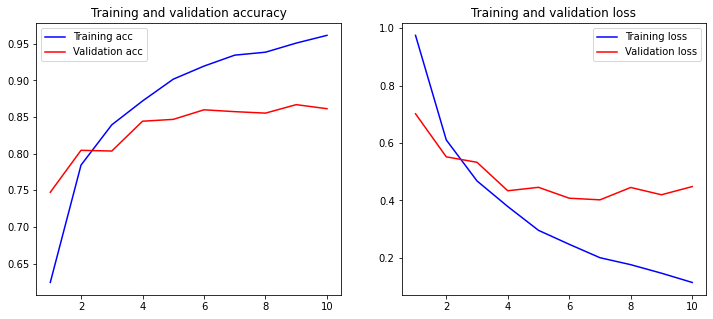

In [ ]:
plot_history(history)

In [ ]:
from statistics import mean, harmonic_mean

model_stats = pd.DataFrame

template = {
    "false_negative": 0,
    "true_negative": 0,
    "false_positive": 0,
    "true_positive": 0,
}

count_list = [template.copy() for i in y_test[0]]

results = model.predict(x=x_test)
correct = 0
incorrect = 0

# goes through resulsts and counts each outcome
for i, result in enumerate(results):
    if np.argmax(result) == np.argmax(y_test[i]):
        correct += 1
        # print('\n')
        # print(np.argmax(result), np.argmax(y_test[i]), 'correct', x_test_text[i])
        # print(result)
        # print('\n')
    else:
        incorrect += 1
        # print('\n')
        # print(np.argmax(result), np.argmax(y_test[i]), 'incorrect', x_test_text[i])
        # print(result)
        # print('\n')
    # print(result)

    for label in range(len(count_list)):
        # print(label)
        if np.argmax(result) == label and np.argmax(y_test[i]) == label:
            count_list[label]['true_positive'] += 1
            # print('TP', label)
        elif np.argmax(result) != label and np.argmax(y_test[i]) == label:
            count_list[label]['false_negative'] += 1
            # print('FN', label)
        elif np.argmax(result) != label and np.argmax(y_test[i]) != label:
            count_list[label]['true_negative'] += 1
            # print('TN', label)
        elif np.argmax(result) == label and np.argmax(y_test[i]) != label:
            count_list[label]['false_positive'] += 1
            # print('FP', label)

    # print('\n')
print(correct, incorrect)

1714 276


In [ ]:
all_precision = []
all_recall = []
all_f1 = []

# calculate statistics about results
for i in range(len(count_list)):
    try:
        precision = count_list[i]['true_positive'] / (count_list[i]['true_positive'] + count_list[i]['false_positive'])
        recall = count_list[i]['true_positive'] / (count_list[i]['true_positive'] + count_list[i]['false_negative'])
        f1 = 2 * (precision * recall) / (precision + recall)
        
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
    except:
        all_precision.append(0)
        all_recall.append(0)
        all_f1.append(0)

for i in range(len(count_list)):
    print(i)
    print(count_list[i])
    print(all_precision[i])
    print(all_recall[i])
    print(all_f1[i])
    print('\n')

0
{'false_negative': 38, 'true_negative': 1572, 'false_positive': 43, 'true_positive': 337}
0.8868421052631579
0.8986666666666666
0.8927152317880793


1
{'false_negative': 101, 'true_negative': 1026, 'false_positive': 69, 'true_positive': 794}
0.9200463499420626
0.8871508379888268
0.9032992036405004


2
{'false_negative': 41, 'true_negative': 1857, 'false_positive': 16, 'true_positive': 76}
0.8260869565217391
0.6495726495726496
0.7272727272727273


3
{'false_negative': 38, 'true_negative': 1664, 'false_positive': 81, 'true_positive': 207}
0.71875
0.8448979591836735
0.776735459662289


4
{'false_negative': 58, 'true_negative': 1565, 'false_positive': 67, 'true_positive': 300}
0.8174386920980926
0.8379888268156425
0.8275862068965517




In [ ]:
df = pd.DataFrame(count_list)
df['precision'] = all_precision
df['recall'] = all_recall
df.to_csv('model_stats.csv')
print(df)

   false_negative  true_negative  false_positive  true_positive  precision  \
0              38           1572              43            337   0.886842   
1             101           1026              69            794   0.920046   
2              41           1857              16             76   0.826087   
3              38           1664              81            207   0.718750   
4              58           1565              67            300   0.817439   

     recall  
0  0.898667  
1  0.887151  
2  0.649573  
3  0.844898  
4  0.837989  


In [ ]:
vape_data = pd.read_csv('/content/youtube-vape-classification/vape-metadata.csv')
keep_columns = vape_data.columns[:13]
vape_data = vape_data[keep_columns]
# print(vape_data.iloc[0])

predict_text = []
for i, row in vape_data.iterrows():

    predict_text.append(preprocess_text(preprocess_text(str(row['Video_Title'])) + ' ' + preprocess_text(str(row['Description']))))

predict_sequence = process_text(predict_text)
predictions = model.predict(predict_sequence, verbose=1)

132/132 [==============================] - 12s 94ms/step


In [ ]:
from langdetect import DetectorFactory
DetectorFactory.seed = 0

for i, row in vape_data.iterrows():
    

    label = np.argmax(predictions[i])
    # langs = detect_langs(predict_text[i])
    # if detect(predict_text[i]) != 'en':
    #     if str(detect_langs(predict_text[i])[0])[5:8] == '999':
    #         label = 'n'
            # print(str(detect_langs(predict_text[i])[0]), predict_text[i])
        
    # print(label, predict_text[i])
    vape_data.at[i, 'model_3_1'] = str(label)
vape_data.to_excel('video_predictions_model_3.xlsx')